In [2]:
# Code to test if GPUs are available
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  
import tensorflow as tf

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

# List available physical devices
gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available:", len(gpus))
print("GPU Details:", gpus)

TensorFlow version: 2.14.0
Num GPUs Available: 2
GPU Details: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [4]:
import os
import numpy as np
import tensorflow as tf 
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_curve, auc, precision_recall_curve, f1_score, roc_auc_score
)

In [5]:
# Image settings
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Step up two folders from current working directory, then into DATA/archive/train
TRAIN_DIR = os.path.abspath(os.path.join("..", "..", "DATA", "archive", "train"))
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=True
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, 
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 8503 images belonging to 2 classes.


In [6]:
# Navigate to the validation folder relative to current script location
VALID_DIR = os.path.abspath(os.path.join("..", "..", "DATA", "archive", "valid"))

valid_datagen = ImageDataGenerator(
    rescale=1./255
)
validation_generator = valid_datagen.flow_from_directory(
    VALID_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 2424 images belonging to 2 classes.


In [8]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

# Load the pretrained base model (frozen)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # freeze pretrained weights

# Build the model with Batch Normalization before activation
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),

    layers.Dense(256),
    layers.BatchNormalization(), # Normalization before activation
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(128),
    layers.BatchNormalization(), # Normalization before activation
    layers.Activation('relu'),
    layers.Dropout(0.3),

    layers.Dense(1, activation='sigmoid')  # Final output for binary classification
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 256)               524544    
                                                                 
 batch_normalization_2 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 activation_2 (Activation)   (None, 256)               0         
                                                                 
 dropout_2 (Dropout)         (None, 256)              

## ***Needed to change this code just as directory structure on my Linux PC is different than yours***

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os

# Ensure save directory exists
os.makedirs("saved_model", exist_ok=True)

# Save best model in HDF5 (.h5) format
checkpoint_cb = ModelCheckpoint(
    filepath="saved_model/best_parking_model.h5",
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    save_format="h5",  # <-- this is crucial when using .h5
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    patience=3,
    factor=0.2,
    verbose=1
)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=20,
    callbacks=[checkpoint_cb, early_stop, reduce_lr]
)

# Save final model and weights using legacy .h5 format
model.save("saved_model/parking_resnet_final.h5")
model.save_weights("saved_model/parking_resnet_weights.h5")


Epoch 1/20
265/265 [==============================] - ETA: 0s - loss: 0.2734 - accuracy: 0.8501
Epoch 1: val_loss improved from inf to 0.79890, saving model to saved_model/best_parking_model.h5


/home/ecube/miniconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


265/265 [==============================] - 80s 302ms/step - loss: 0.2734 - accuracy: 0.8501 - val_loss: 0.7989 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 2/20
265/265 [==============================] - ETA: 0s - loss: 0.2637 - accuracy: 0.8533
Epoch 2: val_loss improved from 0.79890 to 0.60593, saving model to saved_model/best_parking_model.h5
265/265 [==============================] - 81s 307ms/step - loss: 0.2637 - accuracy: 0.8533 - val_loss: 0.6059 - val_accuracy: 0.6379 - lr: 0.0010
Epoch 3/20
265/265 [==============================] - ETA: 0s - loss: 0.2594 - accuracy: 0.8588
Epoch 3: val_loss improved from 0.60593 to 0.25417, saving model to saved_model/best_parking_model.h5
265/265 [==============================] - 81s 304ms/step - loss: 0.2594 - accuracy: 0.8588 - val_loss: 0.2542 - val_accuracy: 0.8642 - lr: 0.0010
Epoch 4/20
265/265 [==============================] - ETA: 0s - loss: 0.2512 - accuracy: 0.8654
Epoch 4: val_loss did not improve from 0.25417
265/265 [===========

# Load the saved model in .h5 format and save it in modern format

In [10]:
# Load the model saved in HDF5 format
model = tf.keras.models.load_model("./saved_model/best_parking_model.h5")

# Save the model in the TensorFlow SavedModel format
model.save("best_parking_model_savedmodel", save_format='tf')

# Verify by loading the SavedModel
loaded_model = tf.keras.models.load_model("best_parking_model_savedmodel")

# Optionally, check the model structure
loaded_model.summary()


INFO:tensorflow:Assets written to: best_parking_model_savedmodel/assets


INFO:tensorflow:Assets written to: best_parking_model_savedmodel/assets


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 batch_normalization_19 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

# ***Function: plot_P-R curve and find threshold for best_F1 . Also plot AUC ROC curve***

In [11]:
def plot_pr_and_roc(model, dataset, set_name="Validation"):
    """
    Unified function to plot P-R and ROC curves, show classification report and confusion matrix
    for both TensorFlow and PyTorch models.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import (
        precision_recall_curve, roc_curve, roc_auc_score,
        classification_report, confusion_matrix, ConfusionMatrixDisplay
    )
    import torch

    is_pytorch_model = isinstance(model, torch.nn.Module)

    if is_pytorch_model:
        model.eval()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)

        y_true = []
        y_scores = []

        with torch.no_grad():
            for images, labels in dataset:
                images = images.to(device)
                outputs = model(images)
                probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1]  # Class 1 (occupied)
                y_scores.extend(probs.cpu().numpy())
                y_true.extend(labels.cpu().numpy())

        y_true = np.array(y_true)
        y_scores = np.array(y_scores)

    else:
        # TensorFlow / Keras
        y_true = np.concatenate([y.numpy() for _, y in dataset], axis=0)
        y_scores = model.predict(dataset).squeeze()

    # === Precision–Recall and F1 ===
    precision, recall, pr_thresholds = precision_recall_curve(y_true, y_scores)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_threshold = pr_thresholds[best_idx]
    best_f1 = f1_scores[best_idx]

    # === ROC Curve and AUC ===
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc_score = roc_auc_score(y_true, y_scores)

    # === Plot PR and ROC curves ===
    plt.figure(figsize=(14, 6))

    # P-R Curve
    plt.subplot(1, 2, 1)
    plt.plot(recall, precision, label=f'{set_name} P-R Curve')
    plt.scatter(recall[best_idx], precision[best_idx], color='red',
                label=f'Best F1={best_f1:.2f} @ Threshold={best_threshold:.2f}')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve ({set_name})")
    plt.grid(True)
    plt.legend()

    # ROC Curve
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}", color='orange')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve ({set_name})")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # === Threshold-based Classification ===
    y_pred = (y_scores >= best_threshold).astype(int)

    # === Print Classification Report ===
    print(f"\nClassification Report ({set_name}):")
    print(classification_report(y_true, y_pred, target_names=["Empty", "Occupied"]))

    # === Plot Confusion Matrix ===
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Empty", "Occupied"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix ({set_name})")
    plt.show()

    # === Summary ===
    print(f"\nBest Threshold by F1 Score: {best_threshold:.2f} (F1 = {best_f1:.2f})")
    print(f"AUC-ROC Score: {auc_score:.4f}")

    return best_threshold, best_f1


# ***Create train_ds, test_ds and valid_ds using resuable function below***

In [12]:
def load_dataset_for_prediction(directory, img_size=(224, 224), batch_size=32):
    """
    Load image dataset for prediction (no shuffling, normalized, with labels).

    Args:
        directory (str): Path to the dataset directory.
        img_size (tuple): Target image size (height, width).
        batch_size (int): Batch size.

    Returns:
        tf.data.Dataset: Prepared dataset (images normalized, labels intact).
    """
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='int',
        image_size=img_size,
        batch_size=batch_size,
        shuffle=False
    )

    # Normalize images to [0, 1]
    dataset = dataset.map(lambda x, y: (x / 255.0, y))
    return dataset

In [13]:
VALID_DIR = os.path.abspath(os.path.join("..", "..", "DATA", "archive", "valid"))  
TEST_DIR = os.path.abspath(os.path.join("..", "..", "DATA", "archive", "test"))
valid_ds = load_dataset_for_prediction(VALID_DIR)
test_ds  = load_dataset_for_prediction(TEST_DIR)

Found 2424 files belonging to 2 classes.
Found 1216 files belonging to 2 classes.


2025-04-12 00:14:45.272858: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600


76/76 [==============================] - 4s 37ms/step


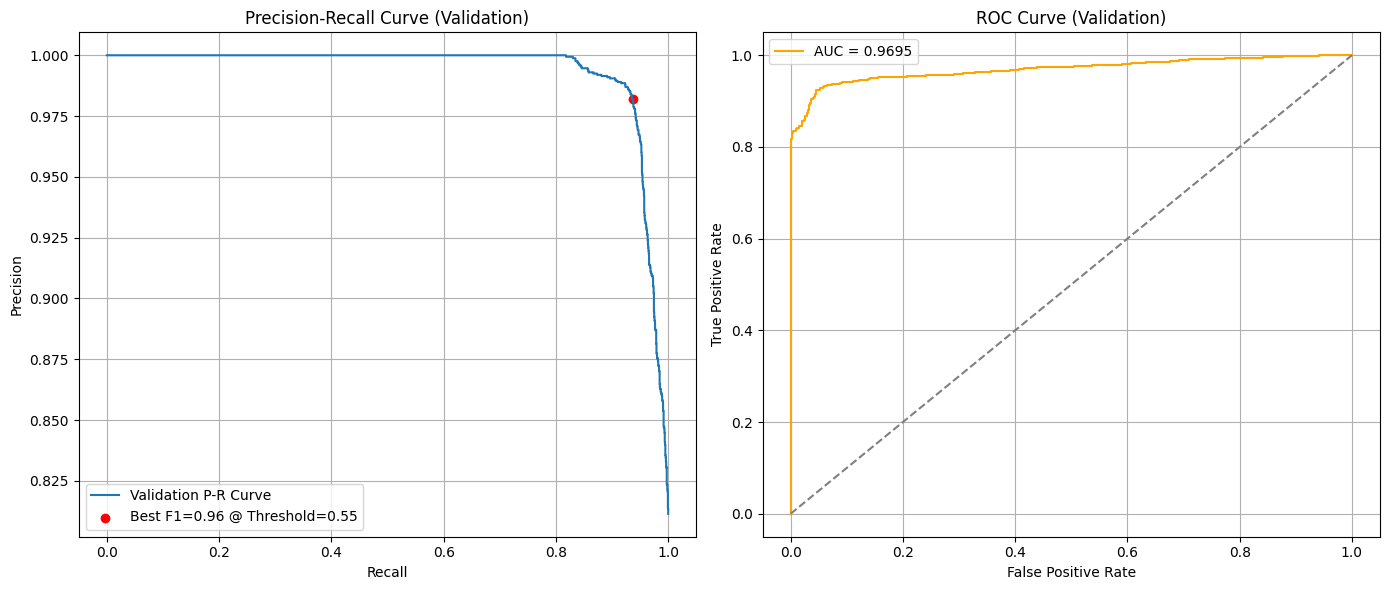


Classification Report (Validation):
              precision    recall  f1-score   support

       Empty       0.77      0.93      0.84       457
    Occupied       0.98      0.94      0.96      1967

    accuracy                           0.94      2424
   macro avg       0.88      0.93      0.90      2424
weighted avg       0.94      0.94      0.94      2424



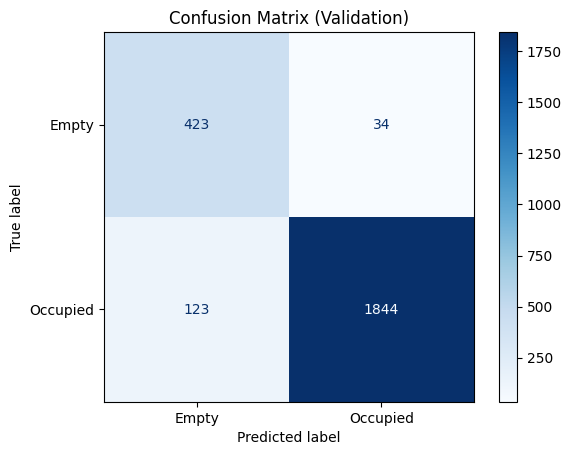


Best Threshold by F1 Score: 0.55 (F1 = 0.96)
AUC-ROC Score: 0.9695


In [14]:
# For validation set
best_threshold, best_f1 = plot_pr_and_roc(model, valid_ds, set_name="Validation")

38/38 [==============================] - 1s 34ms/step


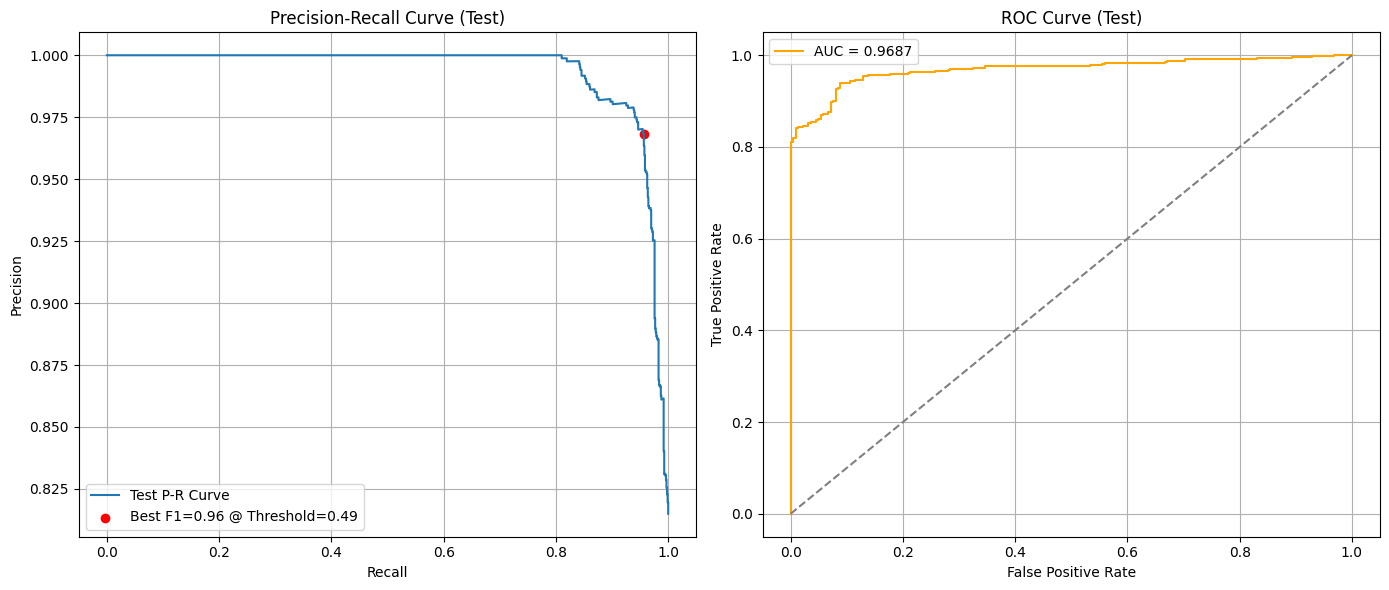


Classification Report (Test):
              precision    recall  f1-score   support

       Empty       0.82      0.86      0.84       225
    Occupied       0.97      0.96      0.96       991

    accuracy                           0.94      1216
   macro avg       0.89      0.91      0.90      1216
weighted avg       0.94      0.94      0.94      1216



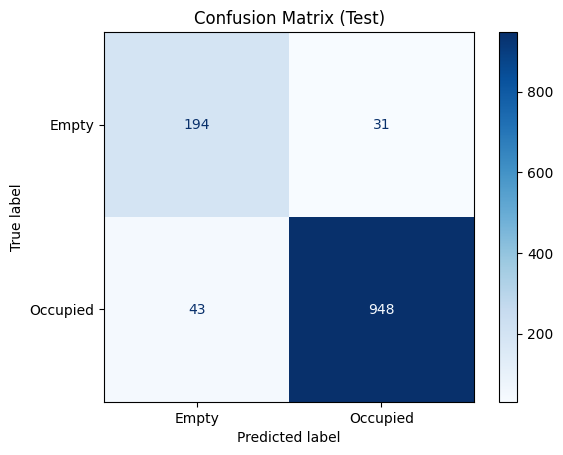


Best Threshold by F1 Score: 0.49 (F1 = 0.96)
AUC-ROC Score: 0.9687


In [15]:
# For test set
best_threshold, best_f1 = plot_pr_and_roc(model, test_ds, set_name="Test")

# ***We define a function to predict on a randomly selected image from 'test' and'valid' set with both threshold***

In [17]:
def predict_random_image(set_type="valid", threshold1=0.55, threshold2=0.49):
    """
    Predict a random image from 'valid' or 'test' set using two thresholds.
    """
    assert set_type in ["valid", "test"], "set_type must be either 'valid' or 'test'"

    # === Constants ===
    HEIGHT, WIDTH = 224, 224
    BASE_DIR = os.path.abspath(os.path.join("..", "..", "DATA", "archive", set_type))
    
    # === Load model ===
    model = load_model("full_model.keras")
    
    # === Get image paths ===
    occupied_paths = glob(os.path.join(BASE_DIR, "occupied", "*.jpg"))
    empty_paths = glob(os.path.join(BASE_DIR, "empty", "*.jpg"))
    all_images = occupied_paths + empty_paths
    
    if not all_images:
        print(f"No images found in {BASE_DIR}")
        return
    
    # === Pick random image ===
    img_path = random.choice(all_images)
    true_label = os.path.basename(os.path.dirname(img_path)).lower()
    
    # === Preprocess ===
    image = cv2.imread(img_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image_rgb, (WIDTH, HEIGHT))
    image_input = np.expand_dims(image_resized, axis=0).astype(np.float32) / 255.0
    
    # === Predict ===
    prob = model.predict(image_input, verbose=0).squeeze()
    pred_1 = "occupied" if prob > threshold1 else "empty"
    pred_2 = "occupied" if prob > threshold2 else "empty"
    
    # === Display ===
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.title(f"True Label: {true_label}")
    plt.show()
    
    # === Print Output ===
    print(f"Set: {set_type.upper()}")
    print(f"Image Path: {img_path}")
    print(f"Predicted Probability: {prob:.4f}")
    print(f"Prediction @ Threshold {threshold1}: {pred_1}")
    print(f"Prediction @ Threshold {threshold2}: {pred_2}")

# ***Predict on a random image from validation set***

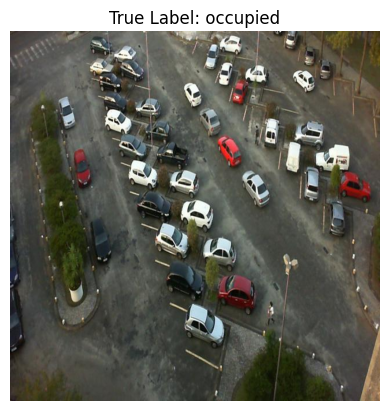

Set: VALID
Image Path: /home/ecube/sandiego/AAI_501_FINAL_TEAM_PROJECT/DATA/archive/valid/occupied/2013-04-09_17_35_13_jpg.rf.b3d5cd8807acfba2bb7bafb815482038.jpg
Predicted Probability: 1.0000
Prediction @ Threshold 0.55: occupied
Prediction @ Threshold 0.49: occupied


In [18]:
# Predict on a random image from validation set
import random
import cv2
predict_random_image(set_type="valid")

# ***Predict on a random image from test set***

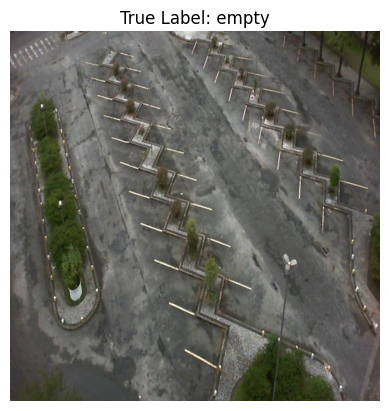

Set: TEST
Image Path: /home/ecube/sandiego/AAI_501_FINAL_TEAM_PROJECT/DATA/archive/test/empty/2013-03-17_07_50_02_jpg.rf.6e2e36b81de635baf1be8d565160f17c.jpg
Predicted Probability: 0.2669
Prediction @ Threshold 0.55: empty
Prediction @ Threshold 0.49: empty


In [19]:
# Predict on a random image from test set
predict_random_image(set_type="test")

# ***STILL AS A MORE SCIENTIFIC WAY WE FIND THRESHOLD THAT WORKS FOR A MIXTURE OF 'test' AND  'valid' IMAGES***

In [20]:
def get_labels_and_scores(model, dataset):
    y_true = []
    y_scores = []

    for images, labels in dataset:
        probs = model.predict(images, verbose=0).squeeze()
        y_true.extend(labels.numpy())
        y_scores.extend(probs)

    return np.array(y_true), np.array(y_scores)


In [35]:
# Run this before the combined P-R/ROC plotting code
y_true_valid, y_scores_valid = get_labels_and_scores(model, valid_ds)
y_true_test, y_scores_test = get_labels_and_scores(model, test_ds)

# Plot P-R curve for combination of valid set and test set images to find a single threshold that can be used for all unknown images

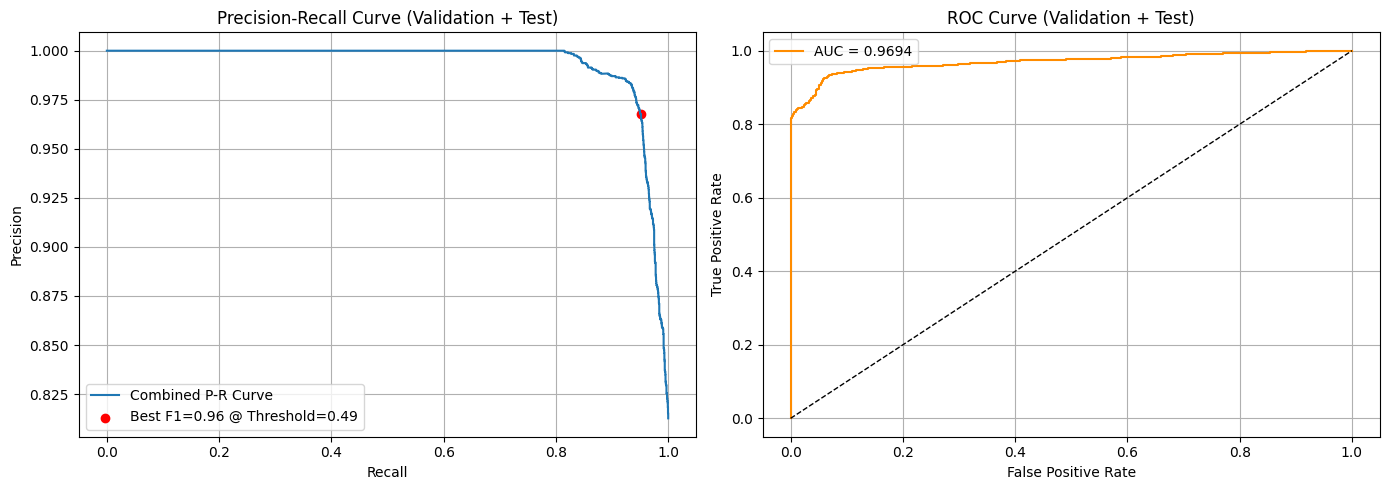

Best Combined Threshold: 0.49
Best F1 Score: 0.96
AUC-ROC Score: 0.9694


In [36]:
# === Step 1: Combine ground truth and scores ===
y_true_combined = np.concatenate([y_true_valid, y_true_test])
y_scores_combined = np.concatenate([y_scores_valid, y_scores_test])

# === Step 2: Precision-Recall Curve ===
precision, recall, thresholds_pr = precision_recall_curve(y_true_combined, y_scores_combined)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds_pr[best_idx]
best_f1 = f1_scores[best_idx]

# === Step 3: ROC Curve and AUC ===
fpr, tpr, thresholds_roc = roc_curve(y_true_combined, y_scores_combined)
auc_score = roc_auc_score(y_true_combined, y_scores_combined)

# === Step 4: Plotting ===
plt.figure(figsize=(14, 5))

# P-R Curve
plt.subplot(1, 2, 1)
plt.plot(recall, precision, label="Combined P-R Curve")
plt.scatter(recall[best_idx], precision[best_idx], color='red',
            label=f"Best F1={best_f1:.2f} @ Threshold={best_threshold:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Validation + Test)")
plt.legend()
plt.grid(True)

# ROC Curve
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='darkorange', label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Validation + Test)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# === Print Metrics ===
print(f"Best Combined Threshold: {best_threshold:.2f}")
print(f"Best F1 Score: {best_f1:.2f}")
print(f"AUC-ROC Score: {auc_score:.4f}")
